In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import time
import os
from tqdm import trange

warnings.filterwarnings('ignore')

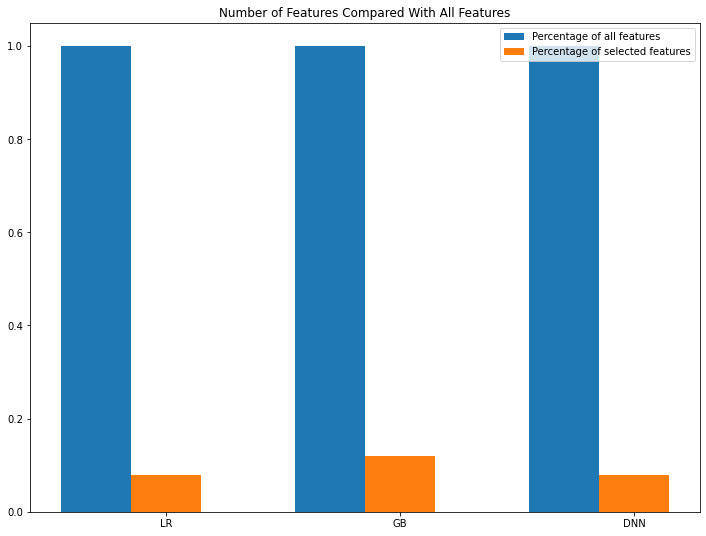

In [19]:
x = ['LR', 'GB', 'DNN']
y = [1, 1, 1]
y2 = [2/25, 3/25, 2/25]

plt.figure(figsize=(12, 9))
plt.bar(x=[1, 2, 3], height=y, width=0.3, label='Percentage of all features')
plt.bar(x=[1.3, 2.3, 3.3], height=y2, width=0.3, label='Percentage of selected features')
plt.xticks(ticks=[1.3, 2.3, 3.3], labels=x)
plt.legend()
plt.title('Number of Features Compared With All Features')
plt.show()

In [7]:
# Load Data
train_raw = pd.read_csv('../Data/KDDCUP99/train.csv')
print(train_raw.shape)

# Seperate label and Drop ID
def LabelEncode(x):
    if x == 'normal.':
        return 0
    else:
        return 1
train_X = train_raw.drop(['type'], axis=1).select_dtypes(include='number')
print(train_X.shape)
train_Y = train_raw['type'].apply(LabelEncode)

# Normalize data with min, max of training data
train_X1 = (train_X - train_X.min(axis=0)) / (train_X.max(axis=0) - train_X.min(axis=0))

train_X1.fillna(0, inplace=True)

(494021, 42)
(494021, 38)


In [8]:
# correlation based feature selection
corr = train_X1.corr().abs()

threshold = 0.8
corr.values[np.tril_indices_from(corr.values)] = np.nan
redundant = []
for j in corr.columns:
    for i in corr.index:
        if corr.loc[i, j] > threshold:
            redundant.append((i, j))

train_X2 = train_X1.copy()
train_X2['type'] = train_Y
corr2 = train_X2.corr().abs()

corr3 = corr2['type'].iloc[:-1].copy()
drop = []

#! modify
for i, j in redundant:
    if corr3[i] > corr3[j]:
        if j not in drop:
            drop.append(j)
    elif i not in drop:
        drop.append(i)
print(drop)

train_X1 = train_X1.drop(drop, axis=1)
print(train_X1.shape)

['num_compromised', 'hot', 'srv_count', 'srv_serror_rate', 'srv_rerror_rate', 'serror_rate', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'rerror_rate']
(494021, 25)


In [9]:
from sklearn.feature_selection import SelectKBest, SelectFromModel, RFE, SequentialFeatureSelector, chi2, f_classif, mutual_info_classif
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score
from sklearnex import patch_sklearn
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [10]:
# greedy search
greedy_all = []
score_functions = [chi2, f_classif, mutual_info_classif]
clfs = [RandomForestClassifier(random_state=0, n_jobs=-1), LogisticRegression(max_iter=10000, random_state=0, n_jobs=-1)]
model = LogisticRegression(max_iter=10000, random_state=0, n_jobs=-1)
for k in trange(train_X1.shape[1]-1):
    features = []
    scores = []
    for sf in score_functions:
        selector = SelectKBest(sf, k=1)
        # select one best feature and add it to subset
        selector.fit(train_X1.drop(greedy_all, axis=1), train_Y)
        f = selector.get_feature_names_out(train_X1.columns.drop(greedy_all))
        features.append(f[0])
        cv = cross_val_score(model, train_X1[greedy_all+[f[0]]], train_Y, scoring='f1', n_jobs=-1)
        scores.append(cv.mean())

    for clf in clfs:
        selector = SequentialFeatureSelector(clf, n_features_to_select=1, scoring='f1', cv=5, n_jobs=-1)
        # select one best feature and add it to subset
        selector.fit(train_X1.drop(greedy_all, axis=1), train_Y)
        f = train_X1.columns.drop(greedy_all)[selector.get_support()]
        features.append(f[0])
        cv = cross_val_score(model, train_X1[greedy_all+[f[0]]], train_Y, scoring='f1', n_jobs=-1)
        scores.append(cv.mean())

    for clf in clfs:
        selector = SelectFromModel(clf, threshold=-np.inf, max_features=1)
        # select one best feature and add it to subset
        selector.fit(train_X1.drop(greedy_all, axis=1), train_Y)
        f = train_X1.columns.drop(greedy_all)[selector.get_support()]
        features.append(f[0])
        cv = cross_val_score(model, train_X1[greedy_all+[f[0]]], train_Y, scoring='f1', n_jobs=-1)
        scores.append(cv.mean())

    count = pd.value_counts(features)
    most_freq_times = count[0]
    meets = count[count==most_freq_times].index

    if len(meets) == 1:
        greedy_all.append(meets[0])
    else:
        features = np.array(features)
        scores = np.array(scores)
        best_score = 0
        for meet in meets:
            index = (features==meet)
            print('meet', meet, scores[index].mean())
            if scores[index].mean() > best_score:
                best_score = scores[index].mean()
                best_feature = meet
        greedy_all.append(best_feature)
greedy_all.append(train_X1.columns.drop(greedy_all)[0])
print(greedy_all)

 12%|█▎        | 3/24 [13:21<1:32:07, 263.22s/it]

meet dst_host_count 0.987439641124787
meet dst_bytes 0.9874732528752709


 29%|██▉       | 7/24 [28:37<1:05:58, 232.83s/it]

meet same_srv_rate 0.9880120208240047
meet dst_host_diff_srv_rate 0.9853058081050363


 46%|████▌     | 11/24 [41:33<43:32, 200.93s/it] 

meet is_guest_login 0.9879311876508297
meet src_bytes 0.9880756491841656


 50%|█████     | 12/24 [44:28<38:35, 192.92s/it]

meet is_guest_login 0.9879311876508297
meet diff_srv_rate 0.9883099752580262


 54%|█████▍    | 13/24 [47:18<34:05, 185.97s/it]

meet is_guest_login 0.9881693600156483
meet dst_host_srv_rerror_rate 0.9884286213655529


100%|██████████| 24/24 [1:09:31<00:00, 173.83s/it]

['count', 'logged_in', 'dst_bytes', 'dst_host_count', 'srv_diff_host_rate', 'dst_host_srv_diff_host_rate', 'same_srv_rate', 'dst_host_diff_srv_rate', 'duration', 'num_access_files', 'src_bytes', 'diff_srv_rate', 'dst_host_srv_rerror_rate', 'num_root', 'num_file_creations', 'is_guest_login', 'wrong_fragment', 'num_shells', 'su_attempted', 'root_shell', 'land', 'urgent', 'num_failed_logins', 'num_outbound_cmds', 'is_host_login']


In [11]:
# test with LR
cv_times_all = []
f1_all = []
model = LogisticRegression(max_iter=10000, random_state=0, n_jobs=-1)
for k in trange(train_X1.shape[1]):
    # cross validation
    second = time.time()
    cv = cross_val_score(model, train_X1[greedy_all[:k+1]], train_Y, scoring='f1', n_jobs=-1)
    second2 = time.time()
    cv_times_all.append(second2 - second)
    f1_all.append((cv.mean(), cv.std()))

100%|██████████| 25/25 [02:03<00:00,  4.94s/it]


In [13]:
pd.DataFrame([cv_times_all], index=['greedy']).to_csv('../Results/KDDCUP99/Greedy_Time_LR.csv')
pd.DataFrame([f1_all], index=['greedy']).to_csv('../Results/KDDCUP99/Greedy_F1_LR.csv')

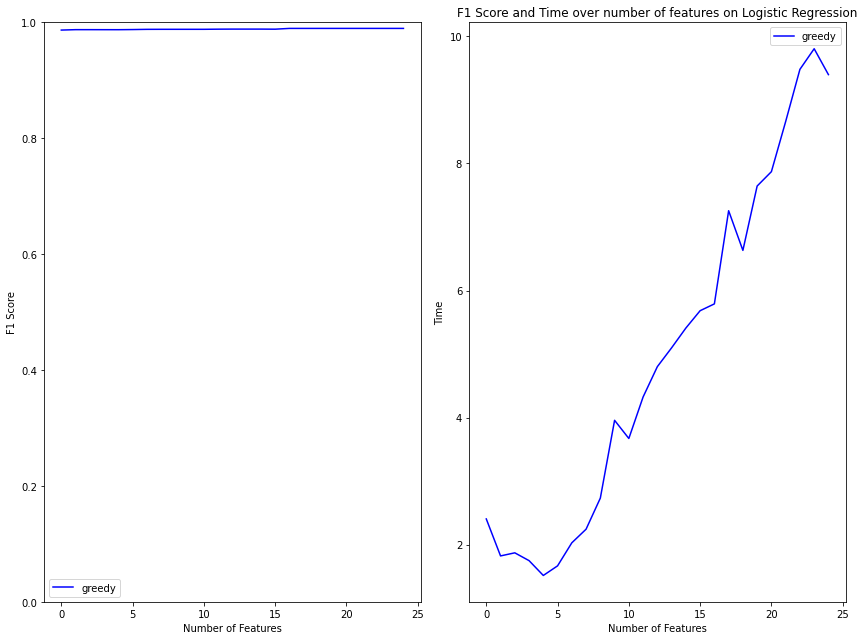

In [14]:
fig, axis = plt.subplots(1, 2, figsize=(12, 9))

plt.title('F1 Score and Time over number of features on Logistic Regression', loc='center')
plt.subplot(1, 2, 1)
plt.xlabel('Number of Features')
plt.ylabel('F1 Score')
plt.ylim((0, 1))

plt.plot(range(train_X1.shape[1]), np.array(f1_all)[:,0], color='blue', linestyle='-', label='greedy')

plt.legend()

plt.subplot(1, 2, 2)
plt.xlabel('Number of Features')
plt.ylabel('Time')

plt.plot(range(train_X1.shape[1]), cv_times_all, color='blue', linestyle='-', label='greedy')

plt.legend()

plt.tight_layout()
plt.show()

In [15]:
# test with GB
cv_times_all = []
f1_all = []
model = GradientBoostingClassifier(random_state=0)
for k in trange(train_X1.shape[1]):
    # cross validation
    second = time.time()
    cv = cross_val_score(model, train_X1[greedy_all[:k+1]], train_Y, scoring='f1', n_jobs=-1)
    second2 = time.time()
    cv_times_all.append(second2 - second)
    f1_all.append((cv.mean(), cv.std()))

100%|██████████| 25/25 [10:33<00:00, 25.32s/it]


In [16]:
pd.DataFrame([cv_times_all], index=['greedy']).to_csv('../Results/KDDCUP99/Greedy_Time_GB.csv')
pd.DataFrame([f1_all], index=['greedy']).to_csv('../Results/KDDCUP99/Greedy_F1_GB.csv')

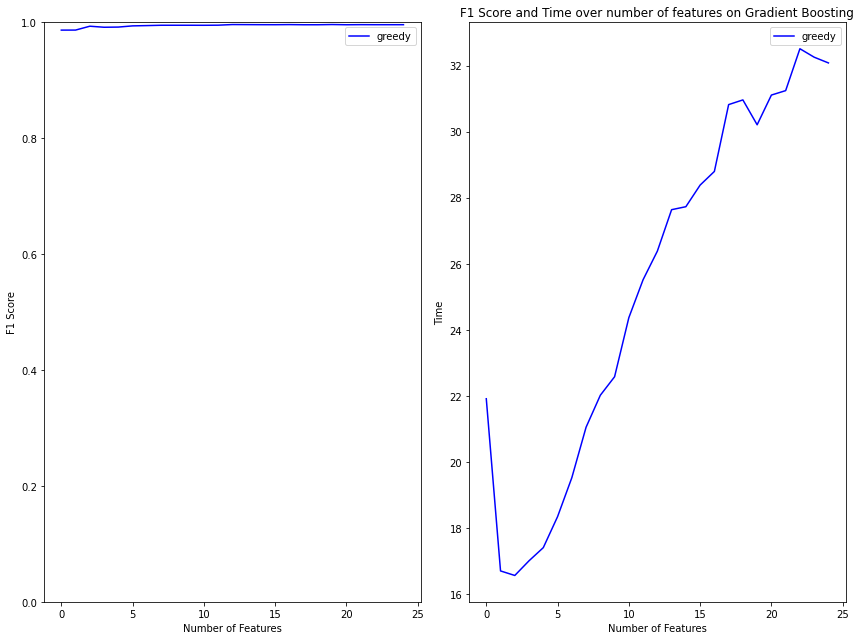

In [17]:
fig, axis = plt.subplots(1, 2, figsize=(12, 9))

plt.title('F1 Score and Time over number of features on Gradient Boosting', loc='center')
plt.subplot(1, 2, 1)
plt.xlabel('Number of Features')
plt.ylabel('F1 Score')
plt.ylim((0, 1))

plt.plot(range(train_X1.shape[1]), np.array(f1_all)[:,0], color='blue', linestyle='-', label='greedy')

plt.legend()

plt.subplot(1, 2, 2)
plt.xlabel('Number of Features')
plt.ylabel('Time')

plt.plot(range(train_X1.shape[1]), cv_times_all, color='blue', linestyle='-', label='greedy')

plt.legend()

plt.tight_layout()
plt.show()

In [18]:
from tensorflow.python.keras import Sequential, layers, losses, metrics, callbacks
from sklearn.model_selection import StratifiedKFold

In [19]:
def ModelCreate(input_shape):
    model = Sequential()
    model.add(layers.Dense(50, activation='relu', input_shape=input_shape))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(50, activation='relu'))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(50, activation='relu'))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(50, activation='relu'))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss=losses.binary_crossentropy, metrics=[metrics.binary_accuracy])
    return model

In [23]:
cv_times_all = []
f1_all = []
kf = StratifiedKFold(shuffle=True, random_state=0)
callback = callbacks.EarlyStopping(patience=3, min_delta=0.1, restore_best_weights=True)
for k in trange(train_X1.shape[1]):
    model = ModelCreate((k+1,))
    # cross validation
    j = 0
    cv_time = 0
    cv = np.zeros(shape=5)
    train_X2 = train_X1[greedy_all[:k+1]].copy()
    for train_index, test_index in kf.split(train_X2, train_Y):
        x_train_fold, x_test_fold = train_X2.iloc[train_index, :], train_X2.iloc[test_index, :]
        y_train_fold, y_test_fold = train_Y.iloc[train_index], train_Y.iloc[test_index]

        second = time.time()
        model.fit(x_train_fold.values, y_train_fold.values, batch_size=1024, validation_data=(x_test_fold, y_test_fold), epochs=30, callbacks=[callback], verbose=0)
        predict = model.predict(x_test_fold, use_multiprocessing=True)
        predict = np.where(predict < 0.5, 0, 1)
        cv[j] = f1_score(y_test_fold, predict)
        second2 = time.time()
        cv_time += second2 - second
        j += 1
    cv_times_all.append(cv_time)
    f1_all.append((cv.mean(), cv.std()))

100%|██████████| 25/25 [17:27<00:00, 41.91s/it]


In [24]:
pd.DataFrame([cv_times_all], index=['greedy']).to_csv('../Results/KDDCUP99/Greedy_Time_DNN.csv')
pd.DataFrame([f1_all], index=['greedy']).to_csv('../Results/KDDCUP99/Greedy_F1_DNN.csv')

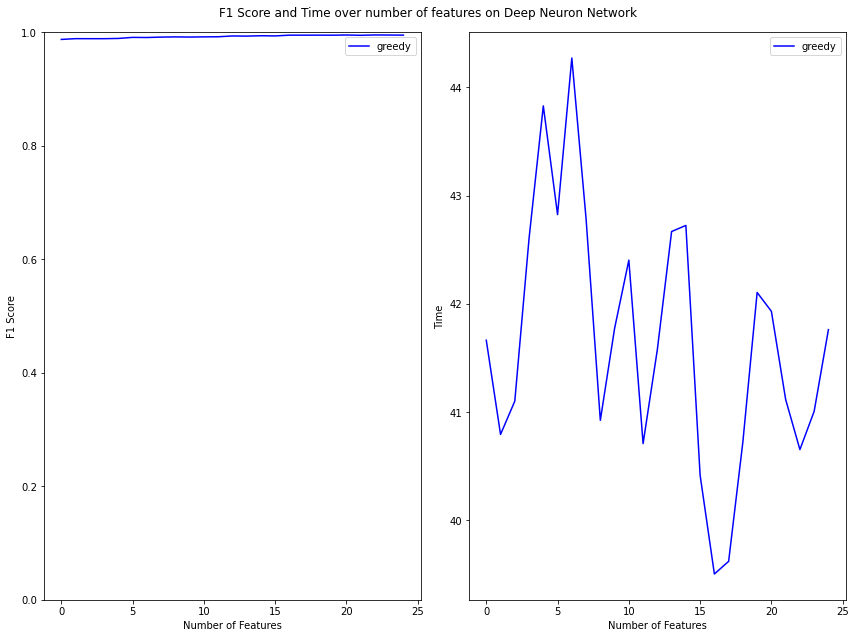

In [27]:
fig, axis = plt.subplots(1, 2, figsize=(12, 9))

plt.suptitle('F1 Score and Time over number of features on Deep Neuron Network')
plt.subplot(1, 2, 1)
plt.xlabel('Number of Features')
plt.ylabel('F1 Score')
plt.ylim((0, 1))

plt.plot(range(train_X1.shape[1]), np.array(f1_all)[:,0], color='blue', linestyle='-', label='greedy')

plt.legend()

plt.subplot(1, 2, 2)
plt.xlabel('Number of Features')
plt.ylabel('Time')

plt.plot(range(train_X1.shape[1]), cv_times_all, color='blue', linestyle='-', label='greedy')

plt.legend()

plt.tight_layout()
plt.show()